In [1]:
# Title: DMRG for Bachelor Thesis
# Author: Aaron Sander
# Date: March 2020

# This program is used for initial learning of tensor network methods
# to be used in my bachelor thesis.
# It is an implementation of Matrix Product States (MPS) and Density Matrix
# Renormalization Group (DMRG) for finding the ground state of an arbitrary
# Hamiltonian

In [2]:
######################### IMPORTS #############################################
import numpy as np
import random as rand
import csv
import matplotlib.pyplot as plt

In [3]:
######################## INITIALIZATIONS ##############################################
def initialize_random_state(numParticles, bondDim):
    # Dimensions (2 x d)
    M_1 = np.random.rand(2, bondDim)

    # Dimensions (d x d x 2)
    M_i = np.random.rand(bondDim, bondDim, 2)


    # Dimensions (2 x d)
    M_N = np.random.rand(2, bondDim)

    MPS = [M_1] + [M_i]*(numParticles-2) + [M_N]
    return MPS


def initialize_W_state(numParticles):
    # d = 2
    # Dimensions (2 x d)
    M_1 = np.array([np.array([1, 0]),
                    np.array([0, 1])])


    # Dimensions (d x d x 2)
    # (2 x d x d) -> (d x d x 2)
    M_i = np.array([np.array([[1, 0],
                              [0, 1]]),
                    np.array([[0, 1],
                              [0, 0]])])
    M_i = np.transpose(M_i, (1, 2, 0))

    # Dimensions (2 x d)
    M_N = np.array([np.array([[0],
                              [1]]),
                    np.array([[1],
                              [0]])])
    M_N = np.squeeze(M_N)

    MPS = [M_1] + [M_i]*(numParticles-2) + [M_N]
    return MPS


def initialize_GHZ_state(numParticles):
    # d = 2
    # Dimensions (2 x d)
    M_1 = np.array([[1, 0], [0, 1]])

    # Dimensions (d x d x 2)
    # (2 x d x d) -> (d x d x 2)
    M_i = np.array([np.array([[1, 0],
                              [0, 0]]),
                    np.array([[0, 0],
                              [0, 1]])])
    M_i = np.transpose(M_i, (1, 2, 0))

    # Dimensions (2 x d)
    M_N = np.array([np.array([[1],
                              [0]]),
                    np.array([[0],
                              [1]])])
    M_N = np.squeeze(M_N)
    
    MPS = [M_1] + [M_i]*(numParticles-2) + [M_N]
    return MPS


### Quantum Ising Model ###
def initialize_quantum_ising(numParticles):
    # Operators
    pauli_z = np.array([[1, 0],
                        [0, -1]])

    pauli_x = np.array([[0, 1],
                        [1, 0]])

    zero = np.zeros((2, 2))
    identity = np.identity(2)

    # Interaction parameter
    g = 2

    # Initialization of Hamiltonian MPO (entries done by hand)
    # Dimensions (1x3x2x2)->(3x2x2)
    left_bound = np.array([identity, pauli_z, g*pauli_x])

    # Dimensions (3x3x2x2)
    inner = np.array([np.array([identity, pauli_z, g*pauli_x]),
                    np.array([zero, zero, pauli_z]),
                    np.array([zero, zero, np.identity(2)])])

    # Dimensions (3x1x2x2)->3x2x2
    right_bound = np.array([[g*pauli_x],
                            [pauli_z],
                            [identity]])
    right_bound = np.squeeze(right_bound)  # Removes unnecessary index

    MPO = [left_bound] + [inner]*(N-2) + [right_bound]

    return MPO

In [4]:
###################### FUNCTIONS FOR MPO ##############################################
# Used to contract tensors horizontally from A->B
# All 2 dimensional tensors have dimensions (ij) or (ab)
# All 3 dimensional tensors have dimensions (ijk) or (abc)
# All 4 dimensional tensors have dimensions (ijkl) or (abcd)

# Examples:
# 4-tensor: Inner MPO
# 3-tensor: Inner MPS, Outer MPO, Half contracted inner MPO-MPS
# 2-tensor: Outer MPS, Half contracted outer MPO-MPS, Fully contracted lattice point

# This all works assuming the MPS has form (2 x d), (d x d x 2), (2 x d)
# Only valid for full system with MPS, MPO, MPS.
# How to read: If we are at tensor A, what other tensor B can I contract with?
def contract_horizontal(A, B, dir):
    if A.ndim == 3:
        if B.ndim == 4: 
            if dir =='right':
                tensor = np.einsum('ijk, ibcd->bjckd', A, B)
                # Reshape to (b, j*c, k*d)
                tensor = np.reshape(tensor, (B.shape[1], A.shape[1]*B.shape[2], A.shape[2]*B.shape[3]))
            elif dir == 'left':
                tensor = np.einsum('ijk, aicd->ajckd', A, B)
                # Reshape to (a, j*c, k*d)
                tensor = np.reshape(tensor, (B.shape[0], A.shape[1]*B.shape[2], A.shape[2]*B.shape[3]))
        elif B.ndim == 3: # Used for contraction of MPO itself
            if dir == 'right' or 'left':  # Can be removed, left for readability
                tensor = np.einsum('ijk, ibc->jbkc', A, B)
                # Reshape collapses indices to (j*b, k*c)
                tensor = np.reshape(tensor, (A.shape[1]*B.shape[1], A.shape[2]*B.shape[2]))
    
    elif A.ndim == 2:
        if B.ndim == 3:
            if dir == 'right':
                tensor = np.einsum('ij, jbc->icb', A, B)
                # Reshape to (i*c, b)
                tensor = np.reshape(tensor, (A.shape[0]*B.shape[2], B.shape[1]))
            elif dir == 'left':
                tensor = np.einsum('ij, ajc->ica', A, B)
                # Reshape to (i*c, a)
                tensor = np.reshape(tensor, (A.shape[0]*B.shape[2], B.shape[0]))
        elif B.ndim == 2:
            if dir == 'right' or 'left': # Direction independent since both MPS edges are (2 x d)
                tensor = np.einsum('ij, aj->ia', A, B)
                # Reshape to (i*b)
                tensor = np.reshape(tensor, (A.shape[0]*B.shape[0]))

    elif A.ndim == 1:
        if B.ndim == 2: # Final contraction before scalar product
            if dir == 'right':
                tensor = np.einsum('i, ib->b', A, B)
            elif dir == 'left':
                tensor = np.einsum('i, ai->a', A, B)
        elif B.ndim == 1: # Inner product
            tensor = np.einsum('i, i', A, B)

    return tensor


def contract_vertical(A, B, dir):
    if A.ndim == 3:
        if B.ndim == 4:
            if dir == 'down' or 'up':
                tensor = np.einsum('ijk, abkd->iajbd', A, B) # Contracts (d x d x 2) and (3 x 3 x 2 x 2)
                # Reshape to (i*a, j*b, d)
                tensor = np.reshape(tensor, (A.shape[0]*B.shape[0], A.shape[1]*B.shape[1], B.shape[3]))
        elif B.ndim == 3:
            if dir == 'down' or 'up': # Contract (3d x 3d x 2) and (d x d x 2)
                tensor = np.einsum('ijk, abk->iajb', A, B)
                # Reshape to (i*a, j*b)
                tensor = np.reshape(tensor, (A.shape[0]*B.shape[0], A.shape[1]*B.shape[1]))

    elif A.ndim == 2:
        if B.ndim == 3:
            if dir == 'down':  # From Bra->Operator->Ket
                tensor = np.einsum('ij, abi->jab', A, B) # Contract (2 x d) and (3 x 2 x 2)
                # Reshape to (j*a, b)
                tensor = np.reshape(tensor, (A.shape[1]*B.shape[0], B.shape[1]))
            elif dir == 'up':  # From Ket->Operator->Bra
                tensor = np.einsum('ij, aic->jac', A, B)
                # Reshape to (j*a, c)
                tensor = np.reshape(tensor, (A.shape[1]*B.shape[0], B.shape[2]))
        elif B.ndim == 2:
            if dir == 'down' or 'up':
                tensor = np.einsum('ij, jb->ib', A, B) # Contract (3d x 2) and (2 x d)
                # Reshape to (i*b)
                tensor = np.reshape(tensor, (A.shape[0]*B.shape[1]))

    return tensor

### Calculates the expectation value by vertical contraction then horizontal contraction ###
def calculate_expectation(MPS_bra, MPO, MPS_ket, vert_dir, horiz_dir):
    # Initialize list of tensors
    tensor = [None]*N

    # Contract <MPS|MPO|MPS> at each lattice position
    # Down: Bra -> MPO -> Ket
    # Up: Ket -> MPO -> Bra
    for i in range(0, N):
        if vert_dir == 'down':
            first_contraction = contract_vertical(MPS_bra[i], MPO[i], vert_dir)
            tensor[i] = contract_vertical(first_contraction, MPS_ket[i], vert_dir)
        if vert_dir == 'up':
            first_contraction = contract_vertical(MPS_ket[i], MPO[i], vert_dir)
            tensor[i] = contract_vertical(first_contraction, MPS_bra[i], vert_dir)

    # Contract each tensor created from above
    # Left and right necessary for scanning in DMRG
    if horiz_dir == 'right':
        E = tensor[0]
        for i in range(1, len(tensor)):
            E = contract_horizontal(E, tensor[i], horiz_dir)
    if horiz_dir == 'left':
        E = tensor[-1]
        for i in range(len(tensor)-2, -1, -1):
            E = contract_horizontal(E, tensor[i], horiz_dir)

    return E

# TODO: Determine if vertical/horizontal can be generalized and combined
# TODO: Cut singular values under a threshold
# NOTE: All directions of contractions have been tested and work correctly.
#       This was verified by checking if result is equal for going
#       left<->right and up<->down.

In [5]:
### CANONICAL FORMS ###

### Normalizes the tensor network such that A_dagger A = Identity ###
def left_normalize(MPS):
    lambda_tensors = []
    # Loop from left bound to right bound
    for i in range(0, len(MPS)):
        # Left bound (2 x d)
        if i == 0:
            M = MPS[i]
            # Dimensions (d x d), (d x 2), (2 x 2)
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)

            MPS[i] = U
            # Contract such that M' = SVM
            MPS[i+1] = np.einsum('ij, jbc->ibc', S @ V, MPS[i+1])
        # Inner tensors (d x d x 2)
        elif i != len(MPS)-1:
            # Reshape such that (d x d x 2) -> (d x 2 x d) for correct reshape
            # Legs closest to each other collape
            M = np.transpose(MPS[i], (0, 2, 1))
            # Collapse left bond and physical dimensions
            M = np.reshape(M, (MPS[i].shape[0]*MPS[i].shape[2], MPS[i].shape[1]))
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)

            # Dimensions according to d x 2 x d still
            # (Left bond, physical dimension, right bond)
            MPS[i] = np.reshape(U, (MPS[i].shape[0], MPS[i].shape[2], U.shape[1]))
            MPS[i] = np.transpose(MPS[i], (0, 2, 1)) # Reshape back to (d x d x 2)

            # Last tensor is a rank-2 tensor
            if i == len(MPS)-2:
                # Transpose due to convention of using 2 x d for last position
                MPS[i+1] = np.einsum('ij, jb->ib', S @ V, MPS[i+1].T).T 
            # Other inner tensors are rank-3 tensors
            else:
                MPS[i+1] = np.einsum('ij, jbc->ibc', S @ V, MPS[i+1])

        # Right bound (2 x d)
        elif i == len(MPS)-1:
            # No right bond dimension exists, so we set it to 1
            M = np.reshape(MPS[i], (MPS[i].shape[0]*MPS[i].shape[1], 1))
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            MPS[i] = np.reshape(U, (MPS[i].shape[0], MPS[i-1].shape[1]))
        lambda_tensors.append(S)

    lambda_tensors.pop(-1)  # Last element is just the norm
    return MPS, lambda_tensors


### Normalizes the tensor network such that B B_dagger = Identity ###
def right_normalize(MPS):
    lambda_tensors = []
    # Loop from right bound to left bound
    for i in range(len(MPS)-1, -1, -1):
        # Right bound (2 x d)
        if i == len(MPS)-1:
            M = MPS[i].T # Needs to be (d x 2)
            # Dimensions (d x d) (d x 2) (2 x 2)
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            MPS[i] = V.T # Transpose so that bond dimension is second
            # Update next position M' = MUS
            MPS[i-1] = np.einsum('ijk, jb->ibk', MPS[i-1], U @ S)

        # Inner tensor
        elif i != 0:
            # Collapse right bond and physical dimension (no need to permute)
            M = np.reshape(MPS[i], (MPS[i].shape[0], MPS[i].shape[1]*MPS[i].shape[2]))

            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            
            # Reshape to (left bond, right bond/previous left bond, physical dim)
            MPS[i] = np.reshape(V, (V.shape[0], MPS[i+1].shape[0], MPS[i].shape[2]))

            # Last tensor is a rank-2 tensor
            if i == 1:
                MPS[i-1] = np.einsum('ij, jk->ik', MPS[i-1], U @ S)
            # Other inner tensors are rank-3 tensors
            else:
                MPS[i-1] = np.einsum('ijk, jb->ibk', MPS[i-1], U @ S)

        # Left bound
        elif i == 0:
            M = np.reshape(MPS[i], (1, MPS[i].shape[0]*MPS[i].shape[1]))
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            MPS[i] = np.reshape(V, (MPS[i].shape[0], MPS[i+1].shape[0]))
        lambda_tensors.append(S)

    lambda_tensors.pop(-1)  # Last element is just the norm
    # lambdas start from right, so need to be reversed
    return MPS, lambda_tensors[::-1]


def contract_outer(bra, ket):
    pos = np.einsum('ij, ib->jb', bra, ket)
    pos = np.reshape(pos, (bra.shape[1]*ket.shape[1]))
    return pos


def contract_inner(bra, ket):
    pos = np.einsum('ijk, abk->iajb', bra, ket)
    pos = np.reshape(pos, (bra.shape[0]*ket.shape[0], bra.shape[1]*ket.shape[1]))
    return pos


### Creates a bond canonical form with left and right normalization on each side of bond ###
def bond_canonical(gamma_tensors, lambda_tensors, bond):
    # Bond i occurs between site i, i+1
    A_tensors = []
    B_tensors = []

    for i in range(0, len(gamma_tensors)):
        if i < bond:
            if i == 0:
                A = gamma_tensors[0]
            else:
                A = np.einsum('ij, jbc->ibc', lambda_tensors[i-1], gamma_tensors[i])
            A_tensors.append(A)
        elif i >= bond:
            if i == len(gamma_tensors)-1:
                B = gamma_tensors[-1]
            else:
                B = np.einsum('ijk, jb->ibk', gamma_tensors[i], lambda_tensors[i])
            B_tensors.append(B)
    MPS = A_tensors + B_tensors
    return MPS


### Creates a site canonical form such as AAAA...M...BBBB ###
### Setting site = N-1 gives us a recreated AA...M state ###
### Setting site = 0 gives us a recreated M...BB state ###
# NOTE: Adding a dummy lambda to left and right could make this more efficient #
def site_canonical(gamma_tensors, lambda_tensors, site):
    # Bond i occurs between site i, i+1
    A_tensors = []
    B_tensors = []

    # Create left canonical matrices
    for i in range(0, len(gamma_tensors)):
        if i < site:
            if i == 0:
                A = gamma_tensors[0]
            else:
                A = np.einsum('ij, jbc->ibc', lambda_tensors[i-1], gamma_tensors[i])
            A_tensors.append(A)

    # Create matrix for optimization
        elif i == site:
            if i == 0:
                M = np.einsum('ij, jb->ib', gamma_tensors[i], lambda_tensors[i])
            elif i == len(gamma_tensors)-1:
                M = np.einsum('ij, aj->ai', lambda_tensors[i-1], gamma_tensors[i])
            else:
                M = np.einsum('ij, jbc, bn->inc', lambda_tensors[i-1], gamma_tensors[i], lambda_tensors[i])

    # Create right canonical matrices
        elif i > site:
            if i == len(gamma_tensors)-1:
                B = gamma_tensors[-1]
            else:
                B = np.einsum('ijk, jb->ibk', gamma_tensors[i], lambda_tensors[i])
            B_tensors.append(B)

    MPS = A_tensors + [M] + B_tensors
    return MPS

In [6]:
### DECOMPOSITIONS AND REBUILDS ###

### Decomposes our MPS into Gamma matrices on sites, Lambda matrices on bonds ###
### Lambda matrices contain the singular values, final lambda matrix is related to norm ###
### Requires a fully left or right normalized state ###
### FINAL GAMMA IS ALSO 2 x d ###
def vidal_notation(tensors, lambda_tensors, normalization):
    # Trim singular values under a threshold, otherwise inverse is hard to calculate
    #threshold = 10e-8
    #for i in range(0, len(lambda_tensors)):
    #    lambda_tensors[i][lambda_tensors[i] < threshold] = 0

    # Calculate inverse matrices
    lambda_inverse = []
    for i in range(0, len(lambda_tensors)):
        try:
            lambda_inverse.append(np.array(np.linalg.inv(lambda_tensors[i])))
        except:
            print("Lambda inverse cannot be calculated.")
            print(lambda_tensors[i])
    
    if normalization == 'left':  # A tensors as input
        A_tensors = tensors[:]
        # Calculate gamma tensors
        gamma_tensors = []
        gamma_tensors.append(A_tensors[0])  # First gamma is just the first A
        for i in range(1, len(A_tensors)-1):
            gamma = np.einsum('ij, jbc->ibc', lambda_inverse[i-1], A_tensors[i])
            gamma_tensors.append(gamma)
        gamma = np.einsum('ij, aj->ai', lambda_inverse[-1], A_tensors[-1]) # XXX Changed from lambda_inverse[-2]
        gamma_tensors.append(gamma)
    
    elif normalization == 'right':  # B tensors as input
        B_tensors = tensors[:]
        # Calculate gamma tensors
        gamma_tensors = []
        gamma = np.einsum('ij, jb->ib', B_tensors[0], lambda_inverse[0])
        gamma_tensors.append(gamma)
        for i in range(1, len(B_tensors)-1):
            gamma = np.einsum('ijk, jb->ibk', B_tensors[i], lambda_inverse[i])
            gamma_tensors.append(gamma)
        gamma_tensors.append(B_tensors[-1])  # Last gamma is just the last B

    return gamma_tensors, lambda_tensors

In [7]:
### METRICS ###

### Calculates scalar product/overlap between two states ###
### <A|B> = N_a*N_b or <A|A> = N^2 = 1/S^2 ###
def scalar_product(A, B):
    pos_0 = np.einsum('ij, ib->jb', A[0], B[0])
    pos_0 = np.reshape(pos_0, (A[0].shape[1]*B[0].shape[1]))
    result = pos_0
    for i in range(1, len(A)-1):
        pos_i = np.einsum('ijk, abk->iajb', A[i], B[i])
        pos_i = np.reshape(pos_i, (A[i].shape[0]*B[i].shape[0], A[i].shape[1]*B[i].shape[1]))
        result = np.einsum('i, ij->j', result, pos_i)
    pos_N = np.einsum('ij, ib->jb', A[-1], B[-1])
    pos_N = np.reshape(pos_N, (A[-1].shape[1]*B[-1].shape[1]))
    result = np.einsum('i, i', result, pos_N)
    return result


### Calculates the distance between two states ###
def overlap(A, B):
    # Cosine similarity, removes error from norm fluctuation
    #overlap = np.sqrt(2 - 2*scalar_product(A, B))
    overlap = np.sqrt(scalar_product(A, A) + scalar_product(B, B) - scalar_product(A, B) - scalar_product(B, A))
    return overlap

In [20]:
### COMPRESSION SWEEPS ###
### Left->right sweep ###
### Bra and Ket are mixed AAMBB-type tensor networks ####
def update_site(bra, ket, site, dir):
    ### L TENSOR WITH SHAPE (bondDim_raw, bondDim_compressed) ###
    for i in range(0, site):
        if i == 0:  # Left bound
            if site == 1:  # L tensor is the left bound only, dimensions flipped to be shape of final L
                L = np.einsum('ij, ib->bj', bra[i], ket[i])
            else:
                L = contract_outer(bra[i], ket[i])
    
        elif i == site-1:  # We need to keep the leg of the bra that connects to the missing tensor
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            # (ia) will connect to previous L, (b) will conect to M, (j) will be left bond of final tensor
            # -> (Left bound, right bound, final tensor left leg)
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], ket[i].shape[1], bra[i].shape[1]))
            # L has shape (Connects to M left bound, final tensor left bound)
            L = np.einsum('i, ibc->bc', L, pos)

        else:  # Inner sites
            pos = contract_inner(bra[i], ket[i])
            L = np.einsum('i, ij->j', L, pos)

    ### M TENSOR AT SITE, UNCHANGED ###
    M = ket[site]

    ### R TENSOR WITH SHAPE (bondDim_raw, bondDim_compressed) ###
    for i in range(len(bra)-1, site, -1):
        if i == len(bra)-1:
            if i == site+1: # R tensor is the right bound only, dimensions flipped to be shape of final R
                R = np.einsum('ij, ib->bj', bra[i], ket[i])
            else:
                R = contract_outer(bra[i], ket[i])

        elif i == site+1:  # We need to keep the leg of the bra that connects to the missing tensor
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            # (a) will conect to M, (jb) will connect to previous R, (i) will be right bond of final tensor
            # -> (Left bound, right bound, final tensor left leg)
            pos = np.reshape(pos, (ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1], bra[i].shape[0]))
            # R has shape (Connects to M right bound, final tensor right bound)
            R = np.einsum('ijk, j->ik', pos, R)

        else:  # Inner sites
            pos = contract_inner(bra[i], ket[i])
            R = np.einsum('ij, j->i', pos, R)

    ### CONTRACT M' = LMR ###
    if site == 0:
        updated_M = np.einsum('ij, jm->im', M, R)
    else:
        updated_M = np.einsum('ij, ibc, bm->jmc', L, M, R)

    ### DECOMPOSING M' INTO NEW GAMMAS AND LAMBDAS ###
    # Inner tensor, similar to left/right normalization 
    if updated_M.ndim == 3:
        reshaped_M = np.transpose(updated_M, (0, 2, 1))  # Move left bond and physical dimension together
        reshaped_M = np.reshape(reshaped_M, (reshaped_M.shape[0]*reshaped_M.shape[1], reshaped_M.shape[2]))
        U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
        A_tensor = np.reshape(U, (bra[site].shape[0], bra[site].shape[2], U.shape[1]))
        A_tensor = np.transpose(A_tensor, (0, 2, 1))
    else:
        U, S_vector, V = np.linalg.svd(updated_M, full_matrices=False)
        A_tensor = U

    lambda_tensor = np.diag(S_vector)

    if dir == 'right':
        if site == len(raw_state)-2:  # Multiplies with matrix on right bound (dim 2 x d)
            new_M = np.einsum('ij, jb, lb->li', lambda_tensor, V, bra[site+1])
        else:
            new_M = np.einsum('ij, jb, bmn->imn', lambda_tensor, V, bra[site+1])        

    return A_tensor, new_M

def sweep_L_to_R(compressed_state_gamma, compressed_state_lambda, raw_state):
    # Initialize site canonical form at first site
    mixed  = site_canonical(compressed_state_gamma, compressed_state_lambda, site = 0)
    
    #Initialize accuracy metrics
    dist = []
    sim = []
    dist.append(overlap(mixed, raw_state))
    if dist[0] > 2:
         print("Initial distance is not in unit sphere. Vectors may not be normalized")
         print("Initial Dist:", dist[0])

    sim.append(scalar_product(mixed, raw_state))
    if sim[0] > 1:
         print("Similarity is not in unit sphere. Vectors may not be normalized")
         print("Initial Sim:", sim[0])

    for site in range(0, len(raw_state)-1):
        # Creates a mixed canonical state from gammas and lambdas of the compressed state
        mixed[site], mixed[site+1] = update_site(mixed, raw_state, site = site, dir = 'right')

        # TODO: Remove from for loop for appending only after each sweep, or add to outside function
        # Checks the overlap and similarity at each site
        dist.append(overlap(mixed, raw_state))
        sim.append(scalar_product(mixed, raw_state))


    return mixed, dist, sim

# TODO: End with mixed canonical with M at first site
def sweep_R_to_L(compressed_state_gamma, compressed_state_lambda, raw_state):
    # Initialize site canonical form at last site
    mixed  = site_canonical(compressed_state_gamma, compressed_state_lambda, site = len(raw_state)-1)
    
    #Initialize accuracy metrics TODO: Put outside function
    #dist = []
    #sim = []
    #dist.append(overlap(mixed, raw_state))
    #if dist[0] > 2:
         #print("Initial distance is not in unit sphere. Vectors may not be normalized")
         #print("Initial Dist:", dist[0])

    #sim.append(scalar_product(mixed, raw_state))
    #if sim[0] > 1:
         #print("Similarity is not in unit sphere. Vectors may not be normalized")
         #print("Initial Sim:", sim[0])

    for site in range(len(raw_state)-1, 0, -1):
        # Creates a mixed canonical state from gammas and lambdas of the compressed state
        mixed[site], mixed[site-1] = update_site(mixed, raw_state, site = site, dir = 'left')

        # TODO: Remove from for loop for appending only after each sweep, or add to outside function
        # Checks the overlap and similarity at each site
        #dist.append(overlap(mixed, raw_state))
        #sim.append(scalar_product(mixed, raw_state))
    return mixed

# Input right normalized compressed state and normalized raw state
def full_sweep(compressed_state, raw_state):
    # State must be right normalized, initial normalization does not matter
    B_tensors, lambda_tensors = right_normalize(compressed_state)

    # We need to calculate the gamma tensors on each site
    gamma_tensors, lambda_tensors = vidal_notation(B_tensors, lambda_tensors, 'right')
    # We sweep left to right across a right-canonical (BBB) MPS to create a left-canonical (AAA) MPS

    compressed_state, dist, sim = sweep_L_to_R(gamma_tensors, lambda_tensors, raw_state)
    print(scalar_product(compressed_state, raw_state))

    # We once again calculate the gamma tensors for our newly left-canonical state
    # NOTE: The state is already left normalized, so this is just to calculate the lambda tensors
    A_tensors, lambda_tensors = left_normalize(compressed_state)
    gamma_tensors, lambda_tensors = vidal_notation(A_tensors, lambda_tensors, 'left') 

    # The state is already normalized, so now we break it into gamma and lambda tensors
    #compressed_state_A, compressed_state_lambda = left_normalize(compressed_state[:])
    #compressed_state_gamma, compressed_state_lambda, dist, sim = sweep_R_to_L(compressed_state_gamma, compressed_state_lambda, raw_state)

    return compressed_state, dist, sim


0.9391518371259848


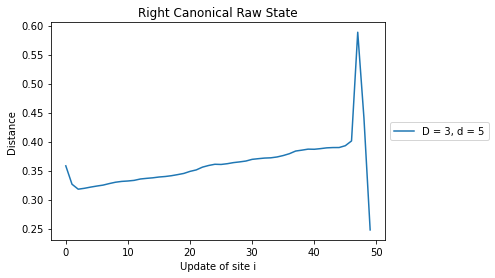

In [36]:
N = 50
D = 3
d = 5

# Initializes random state MPS
raw_state = initialize_random_state(N, D)
# Left sweep requires a right normalized function to begin
raw_state, _ = right_normalize(raw_state)

# Initialize compressed state MPS of desired size
compressed_state = initialize_random_state(N, d)

# State must be right normalized before beginning
_, dist, sim = full_sweep(compressed_state, raw_state)



x = range(0, len(raw_state))
plt.figure()
plt.title("Right Canonical Raw State")
plt.xlabel("Update of site i")
plt.ylabel("Distance")
plt.plot(x, dist, label="D = %d, d = %d" %(D, d))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [33]:
N = 50
D = 15
d = 5

# Initializes random state MPS
raw_state = initialize_random_state(N, D)
# Left sweep requires a right normalized function to begin
raw_state, _ = right_normalize(raw_state)

# Initialize compressed state MPS of desired size
initial_compressed_state = initialize_random_state(N, d)

# State must be right normalized before beginning
B_tensors, lambda_tensors = right_normalize(compressed_state)
gamma_tensors, lambda_tensors = vidal_notation(B_tensors, lambda_tensors, 'right')
compressed_state, dist, sim = sweep_L_to_R(gamma_tensors, lambda_tensors, raw_state)

x = range(0, len(raw_state))
plt.figure()
plt.title("Right Canonical Raw State")
plt.xlabel("Update of site i")
plt.ylabel("Distance")
plt.plot(x, sim, label="D = %d, d = %d" %(D, d))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (30,)->(30,) (4,)->(4,) 

In [53]:
def test_canonical(MPS):
    ### LEFT CANONICAL FORM ###
    # Information in DMRG Schollwöck 4.4 and Delft MPS lecture
    # Goal: Contract left dimension and physical dimension to get identity at all sites
    
    # First site has left dimension 1, so we contract physical dimension
    # (2 x d)
    print("A Canonical Check \n")
    test_identity = np.einsum('ij, ib->jb', MPS[0], MPS[0])
    print("Pos", "0", ":\n", test_identity)
    for i in range(1, len(MPS)-1):
        # We contract left dimension and physical dimension for each site
        # (d x d x 2)
        test_identity = np.einsum('ijk, ibk->jb', MPS[i], MPS[i])
        print("Pos", i, ":\n", test_identity)
    # Last site has right dimension 1, so result is a singular number
    # If all other matrices are identity, it is also the norm
    # (2 x d)
    test_identity = np.einsum('ij, ij', MPS[-1], MPS[-1])
    print("Pos", N-1, ":\n", test_identity)

    ## RIGHT CANONICAL FORM ####
    # Goal: Contract right dimension and physical dimension to get identity at all sites
    print("\nB Canonical Check \n")
    # First site has right dimension 1, so we contract physical dimension
    test_identity = np.einsum('ij, ib->jb', MPS[-1], MPS[-1])
    print("Pos", N-1, ":\n", test_identity)
    for i in range(len(MPS)-2, 0, -1):
        # We contract right dimension and physical dimension for each site
        test_identity = np.einsum('ijk, ajk->ia', MPS[i], MPS[i])
        print("Pos", i, ":\n", test_identity)
    # Last site has right dimension 1, so result is a singular number
    # If all other matrices are identity, it is also the norm
    test_identity = np.einsum('ij, ij', MPS[0], MPS[0])
    print("Pos", 0, ":\n", test_identity)

In [54]:
test_canonical(compressed_state)

e-19 -2.94902991e-17 -1.99493200e-17  4.16333634e-17
   1.00000000e+00]]
Pos 47 :
 [[ 1.00000000e+00 -1.50189106e-16 -2.46520469e-17  2.45029691e-17]
 [-1.50189106e-16  1.00000000e+00 -1.11022302e-16 -2.77555756e-16]
 [-2.46520469e-17 -1.11022302e-16  1.00000000e+00 -1.24900090e-16]
 [ 2.45029691e-17 -2.77555756e-16 -1.24900090e-16  1.00000000e+00]]
Pos 48 :
 [[1.00000000e+00 4.07287322e-17]
 [4.07287322e-17 1.00000000e+00]]
Pos 49 :
 0.9998945631373608

B Canonical Check 

Pos 49 :
 [[9.99753902e-01 0.00000000e+00]
 [0.00000000e+00 1.40661005e-04]]
Pos 48 :
 [[ 1.99674310e+00  9.82740212e-03 -2.24350172e-02  4.88164886e-03]
 [ 9.82740212e-03  7.18421099e-05 -1.72747939e-04  3.16304963e-05]
 [-2.24350172e-02 -1.72747939e-04  1.53198270e-03 -1.42633689e-03]
 [ 4.88164886e-03  3.16304963e-05 -1.42633689e-03  1.65307068e-03]]
Pos 47 :
 [[ 1.86156144 -0.04929867 -0.13622089  0.04258598 -0.20845626]
 [-0.04929867  0.92200901  0.26103913  0.15658304  0.09875126]
 [-0.13622089  0.26103913  0.

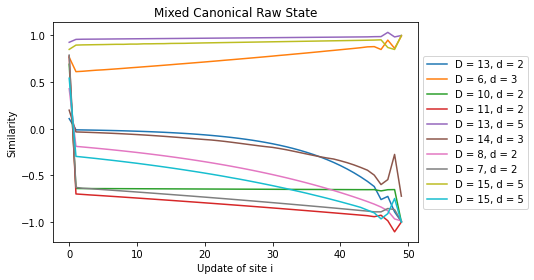

In [62]:
### CREATION OF PLOTS FOR ANALYZING ONE SWEEP ###

plot1 = plt.axes()
plt.title("Mixed Canonical Raw State")
plt.xlabel("Update of site i")
plt.ylabel("Similarity")

plt.tight_layout()
for i in range(10):
    N   = 50
    D = rand.randint(6, 15)
    d = rand.randint(2, 5)

    raw_state = initialize_random_state(N, D)
    raw_state, _ = right_normalize(raw_state)  # Change this for normalization test, must be right for mixed canonical

    initial_compressed_state = initialize_random_state(N, d)
    compressed_state, dist, sim = sweep_L_to_R(initial_compressed_state, raw_state)

    x = range(0, len(raw_state))    
    plt.plot(x, sim, label="D = %d, d = %d" %(D, d))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
### Scanning over possible raw states to check how closely a lower dimension state approximates it using one sweep ###
### Averaged over 50 random initial states to avoid local minima ###
# with open('one_sweep_tests.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Points", "Raw Dim", "Compressed Dim", "Worst Similarity", "Best Similarity", "Worst Distance", "Best Distance"])

#     for N in range(3, 21):
#         # For checking progress
#         print(N)
#         for D in range(3, 21):
#             # Create a normalized state with bond dimension D
#             raw_state = initialize_random_state(numParticles = N, bondDim = D)
#             raw_state, _ = right_normalize(raw_state[:])
#             for d in range(2, D):
#                 # Check how close we can approximate it for all lower bond dimensions d
#                 best_sim = 0
#                 best_dist = 10e8
#                 worst_sim = 10e8
#                 worst_dist = 0

#                 # Averaged over 50 initial states
#                 for i in range(50):
#                     initial_compressed_state = initialize_random_state(numParticles = N, bondDim = d)
#                     try:  # In case of a singular matrix, we need to just generate a new state
#                         compressed_state, sim, dist = sweep_L_to_R(initial_compressed_state, raw_state)
#                     except:
#                         continue
#                     if sim > best_sim:
#                         best_sim = sim
#                     if sim < worst_sim:
#                         worst_sim = sim

#                     if dist < best_dist:
#                         best_dist = dist
#                     if dist > worst_dist:
#                         worst_dist = dist

#                 writer.writerow([N, D, d, worst_sim, best_sim, worst_dist, best_dist])

3
4
5
6


In [37]:
### CHECK THAT BOND CANONICAL PROPERLY CREATED ###
# test_identity = np.einsum('ij, ib->jb', A_tensors[0], A_tensors[0])
# print("Pos", "1", ":\n", test_identity)
# for i in range(1, len(A_tensors)):
#     # We contract left dimension and physical dimension for each site
#     # (d x d x 2)
#     test_identity = np.einsum('ijk, ibk->jb', A_tensors[i], A_tensors[i])
#     print("Pos", i+1, ":\n", test_identity)

# for i in range(0, len(B_tensors)-1):
#     # We contract right dimension and physical dimension for each site
#     test_identity = np.einsum('ijk, ajk->ia', B_tensors[i], B_tensors[i])
#     print("Pos", i+1+len(A_tensors), ":\n", test_identity)
# test_identity = np.einsum('ij, ib->jb', B_tensors[-1], B_tensors[-1])
# print("Pos", N, ":\n", test_identity)

In [38]:
### BOND CANONICAL WORKS FOR ALL BONDS ###
# for i in range(1, N-1):
#     A_tensors, B_tensors, lambda_bond = bond_canonical(gamma_tensors, lambda_tensors, bond=i)

In [39]:
### MANUAL CHECK A DECOMPOSITION ###
# if (A_tensors[0].all() != gamma_tensors[0].all()):
#     print("Error at tensor 0")
# for i in range(1, len(gamma_tensors)):
#     if i != len(gamma_tensors)-1:  # Inner tensors
#         A_recreated = np.einsum('ij, jbc->ibc', lambda_tensors[i-1], gamma_tensors[i])
#     else:
#         A_recreated = np.einsum('ij, aj->ia', lambda_tensors[-2], gamma_tensors[-1])
#     if (A_tensors[i].all() != A_recreated.all()):
#         print("Error at tensor", i)

In [40]:
### MANUAL CHECK B DECOMPOSITION ###
# if (B_tensors[-1].all() != gamma_tensors[-1].all()):
#     print("Error at tensor -1")
# for i in range(len(A_tensors), len(gamma_tensors)):
#     if i != len(gamma_tensors)-1:  # Inner tensors
#         B_recreated = np.einsum('ijk, jb->ibk', gamma_tensors[i], lambda_tensors[i])
#     if (B_tensors[i-len(A_tensors)].all() != B_recreated.all()):
#         print("Error at tensor", i)

In [41]:
# ### MANUAL CHECK NORM #####
# temp0 = np.einsum('ij, ib->jb', MPS[0], MPS[0])
# temp0 = np.reshape(temp0, (MPS[0].shape[1]**2))

# norm = temp0
# for i in range(1, len(MPS)-1):
#     temp = np.einsum('ijk, abk->iajb', MPS[i], MPS[i])
#     temp = np.reshape(temp, (MPS[i].shape[0]**2, MPS[i].shape[1]**2))
#     norm = np.einsum('i, ij->j', norm, temp)
# temp = np.einsum('ij, ib->jb', MPS[-1], MPS[-1])
# temp = np.reshape(temp, (MPS[-1].shape[1]**2))
# norm = np.einsum('i, i', norm, temp)
# print(np.sqrt(norm))

In [29]:
### MANUAL CHECK LEFT CANONICAL FORM ####
# Information in DMRG Schollwöck 4.4 and Delft MPS lecture
# Goal: Contract left dimension and physical dimension to get identity at all sites

MPS = compressed_state[:]
# First site has left dimension 1, so we contract physical dimension
# (2 x d)

print("A Canonical Check \n")
test_identity = np.einsum('ij, ib->jb', MPS[0], MPS[0])
print("Pos", "0", ":\n", test_identity)
for i in range(1, len(MPS)-1):
    # We contract left dimension and physical dimension for each site
    # (d x d x 2)
    test_identity = np.einsum('ijk, ibk->jb', MPS[i], MPS[i])
    print("Pos", i, ":\n", test_identity)
# Last site has right dimension 1, so result is a singular number
# If all other matrices are identity, it is also the norm
# (2 x d)
test_identity = np.einsum('ij, ij', MPS[-1], MPS[-1])
print("Pos", N-1, ":\n", test_identity)


## MANUAL CHECK RIGHT CANONICAL FORM ####
#Information in DMRG Schollwöck 4.4 and Delft MPS lecture
#Goal: Contract right dimension and physical dimension to get identity at all sites
print("\nB Canonical Check \n")
# First site has right dimension 1, so we contract physical dimension
test_identity = np.einsum('ij, ib->jb', MPS[-1], MPS[-1])
print("Pos", N-1, ":\n", test_identity)
for i in range(len(MPS)-2, 0, -1):
    # We contract right dimension and physical dimension for each site
    test_identity = np.einsum('ijk, ajk->ia', MPS[i], MPS[i])
    print("Pos", i, ":\n", test_identity)
# Last site has right dimension 1, so result is a singular number
# If all other matrices are identity, it is also the norm
test_identity = np.einsum('ij, ij', MPS[0], MPS[0])
print("Pos", 0, ":\n", test_identity)

A Canonical Check 

Pos 0 :
 [[1. 0.]
 [0. 1.]]
Pos 1 :
 [[ 1.00000000e+00 -9.21571847e-17]
 [-9.21571847e-17  1.00000000e+00]]
Pos 2 :
 [[1. 0.]
 [0. 1.]]
Pos 3 :
 [[ 1.0000000e+00 -3.6429193e-17]
 [-3.6429193e-17  1.0000000e+00]]
Pos 4 :
 0.9999999999999998

B Canonical Check 

Pos 4 :
 [[0.99781468 0.        ]
 [0.         0.00218532]]
Pos 3 :
 [[ 1.81672466 -0.2923805 ]
 [-0.2923805   0.18327534]]
Pos 2 :
 [[0.00445978 0.07790147]
 [0.07790147 1.99554022]]
Pos 1 :
 [[1.82690496 0.36012238]
 [0.36012238 0.17309504]]
Pos 0 :
 2.0


In [30]:
######################## EXPECTATION VALUE #############################################
# E_D_R = calculate_expectation(MPS, MPO, MPS, 'down', 'right')
# E_D_L = calculate_expectation(MPS, MPO, MPS, 'down', 'left')
# E_U_R = calculate_expectation(MPS, MPO, MPS, 'up', 'right')
# E_U_L = calculate_expectation(MPS, MPO, MPS, 'up', 'left')

# # Rounding necessary since sometimes the values are slightly off
# # Most likely due to rounding errors in computation
# if (np.round(E_D_R, 5) == np.round(E_D_L, 5)
#                        == np.round(E_U_R, 5)
#                        == np.round(E_U_L, 5)):
#     print("Expectation value is the same in all directions")
# print(E_D_R, E_D_L, E_U_R, E_U_L)

Expectation value is the same in all directions
3.684460150424682 3.6844601504246834 3.684460150424682 3.6844601504246834


In [23]:
# # ####### CONTRACT HAMILTONIAN LEFT AND RIGHT ########
# temp = contract_horizontal(MPO[0], MPO[1], 'right')
# H_right = contract_horizontal(temp, MPO[2], 'right')
# temp = contract_horizontal(MPO[2], MPO[1], 'left')
# H_left = contract_horizontal(temp, MPO[0], 'left')
# if (H_right.all() == H_left.all()):
#     print("Hamiltonian contracts correctly")

In [24]:
# # ######## EXPECTATION VALUE DOWN, RIGHT ##########
# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'down')
# left = contract_vertical(temp, MPS[0], 'down')

# # Inner lattice bra->H->ket
# temp = contract_vertical(MPS[1], MPO[1], 'down')
# inner = contract_vertical(temp, MPS[1], 'down')

# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'down')
# right = contract_vertical(temp, MPS[2], 'down')

# temp = contract_horizontal(left, inner, 'right')
# E_down_right = contract_horizontal(temp, right, 'right')

# ###### EXPECTATION VALUE UP, RIGHT ###########
# # Left lattice ket->H->bra
# temp = contract_vertical(MPS[0], MPO[0], 'up')
# left = contract_vertical(temp, MPS[0], 'up')

# # Inner lattice ket->H->bra
# temp = contract_vertical(MPS[1], MPO[1], 'up')
# inner = contract_vertical(temp, MPS[1], 'up')

# # Right lattice ket->H->bra
# temp = contract_vertical(MPS[2], MPO[2], 'up')
# right = contract_vertical(temp, MPS[2], 'up')

# temp = contract_horizontal(left, inner, 'right')
# E_up_right = contract_horizontal(temp, right, 'right')

# ###### EXPECTATION VALUE UP, LEFT ###########
# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'up')
# right = contract_vertical(temp, MPS[2], 'up')

# # Inner lattice bra->H->ket
# temp = contract_vertical(MPS[1], MPO[1], 'up')
# inner = contract_vertical(temp, MPS[1], 'up')

# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'up')
# left = contract_vertical(temp, MPS[0], 'up')

# temp = contract_horizontal(right, inner, 'left')
# E_up_left = contract_horizontal(temp, left, 'left')

# ###### EXPECTATION VALUE DOWN, LEFT ###########
# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'down')
# right = contract_vertical(temp, MPS[2], 'down')

# # Inner lattice bra->H->ket
# temp = contract_vertical(MPS[1], MPO[1], 'down')
# inner = contract_vertical(temp, MPS[1], 'down')

# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'down')
# left = contract_vertical(temp, MPS[0], 'down')

# temp = contract_horizontal(right, inner, 'left')
# E_down_left = contract_horizontal(temp, left, 'left')

# ######## EXPECTATION VALUE ZIG-ZAG ##########
# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'down')
# left = contract_vertical(temp, MPS[0], 'down')

# # Inner lattice ket->H->bra
# temp = contract_vertical(MPS[1], MPO[1], 'up')
# inner = contract_vertical(temp, MPS[1], 'up')

# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'down')
# right = contract_vertical(temp, MPS[2], 'down')

# temp = contract_horizontal(left, inner, 'right')
# E_zig_zag = contract_horizontal(temp, right, 'right')

# if (E_down_right.all() == E_down_left.all() == E_up_right.all() == E_up_left.all() == E_zig_zag.all()):
#      print("Expectation value contracts in all directions correctly")